# Tutorial on interpreting smartphone-based inertial sensor data though <br>Layer-Wise Relevance Propagtion (LRP)
This notebook will detail an example for implementing Layer-Wise Relevance Propagtion (LRP) [2-3] to visualse deep convolutional neural network (DCNN) decisions applied to smartphone-based inertial sensor data collected from healthy controls (HC), people with mild MS (PwMSmild), and people with moderate MS (PwMSmild) based on the work presented in [1]. The analysis condicted in this notebook is based on previous work on gait by Horst _et al_. (2019) [4]. This study  implemented LRP to attribute segments of a DNNs predictions back to the input signal, which were collected from ground reaction force plates and motion capture full-body joint angles. This first work reliably demonstrated how LRP could characterise temporal gait patterns, and explained the nuances of particular gait characteristics that distinguished between individual participants in detail. For example, LRP identified how one individual had a greater extension of an ankle during a specific phase of the gait cycle. While this work demonstrated how gait patterns can be uniquely associated to an individual, and established this through LRP explanations, an extension of this rationale is that there are gait patterns characteristic of a disease, or diseased sub-population. <br>

Ths example utilises average smartphone-based inertial sensor epochs that are "representative" of HC, PwMSmild and PwMSmod subject groups. Representative epochs were created using Dynamic Time Warping Barycenter Averaging (DBA) [5-6], generating average epochs from sets of correctly classified HC, PwMSmild and PwMSmod epochs. 

In [1]:
#dependencies 
import numpy as np
import pandas as pd
import scipy.io as spio
import h5py
import os
from keras.models import load_model
from os.path import expanduser
home = expanduser("~")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
#ignore deprecation warnings associated with TF 2.0
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

save_pathname=os.getcwd() + '/results/'
if not os.path.isdir(save_pathname):
    os.mkdir(save_pathname)

Using TensorFlow backend.


## Dynamic Time Warping Barycenter Averaging (DBA)
An average representative epoch was generated for each subject-group using Dynamic Time Warping Barycenter Averaging (DBA) [5-6]. First, Dynamic Time Warping (DTW) is a method to measure the similarity (distance) between two sequences in cases where the order of elements in the sequences must be considered. DTW can be used to align the signals such that the similarity between their points is minimised, hence generating a “warped” optimal alignment between sequences. Representative average epochs (n=128 samples, 2.56 seconds) were first created using Dynamic Time Warping Barycenter Averaging (DBA) independently for sets of correctly classified epochs from HC, PwMSmild and PwMSmod subject groups. An implementation of DBA can be found at https://github.com/fpetitjean/DBA/.

In [2]:
#load the pre-processed DBA average epochs for HC, PwMSmild and PwMSmod subject groups
pathname= os.getcwd() + '/data/'
filename_HC='X_DBA_HC'
filename_PwMSmild='X_DBA_PwMSmild'
filename_PwMSmod='X_DBA_PwMSmod'

#Load HC Data
X_HC = h5py.File(pathname + filename_HC + '.mat',  'r')
X_HC = X_HC["X_DBA"]
X_HC=np.transpose(X_HC,(1, 0))
X_HC=np.reshape(X_HC, (1, 128, 4))

#Load PwMSmild Data
X_PwMSmild = h5py.File(pathname + filename_PwMSmild + '.mat',  'r')
X_PwMSmild = X_PwMSmild["X_DBA"]
X_PwMSmild=np.transpose(X_PwMSmild,(1, 0))
X_PwMSmild=np.reshape(X_PwMSmild, (1, 128, 4))

#Load PwMSmod Data
X_PwMSmod = h5py.File(pathname + filename_PwMSmod + '.mat',  'r')
X_PwMSmod = X_PwMSmod["X_DBA"]
X_PwMSmod=np.transpose(X_PwMSmod,(1, 0))
X_PwMSmod=np.reshape(X_PwMSmod, (1, 128, 4))

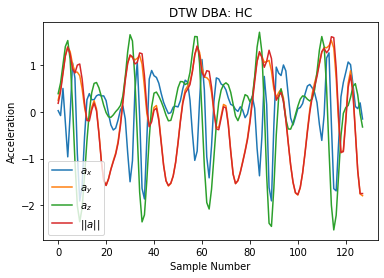

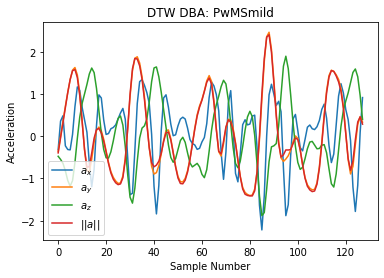

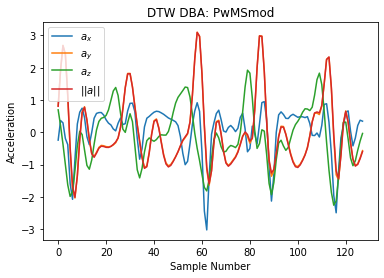

In [3]:
#plot the data for each label
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
    
plt.figure()
plt.plot(X_HC[0,:,0], label='$a_x$')
plt.plot(X_HC[0,:,1], label='$a_y$')
plt.plot(X_HC[0,:,2], label='$a_z$')
plt.plot(X_HC[0,:,3], label='$||a||$')
plt.title('DTW DBA: HC')
plt.xlabel('Sample Number')
plt.ylabel('Acceleration')
plt.legend()
plt.show()


plt.figure()
plt.plot(X_PwMSmild[0,:,0], label='$a_x$')
plt.plot(X_PwMSmild[0,:,1], label='$a_y$')
plt.plot(X_PwMSmild[0,:,2], label='$a_z$')
plt.plot(X_PwMSmild[0,:,3], label='$||a||$')
plt.title('DTW DBA: PwMSmild')
plt.xlabel('Sample Number')
plt.ylabel('Acceleration')
plt.legend()
plt.show()

hc_index=0
plt.figure()
plt.plot(X_PwMSmod[0,:,0], label='$a_x$')
plt.plot(X_PwMSmod[0,:,1], label='$a_y$')
plt.plot(X_PwMSmod[0,:,2], label='$a_z$')
plt.plot(X_PwMSmod[0,:,3], label='$||a||$')
plt.title('DTW DBA: PwMSmod')
plt.xlabel('Sample Number')
plt.ylabel('Acceleration')
plt.legend()
plt.show()

In [4]:
#load the trained (multi-class)disease-classification model
model_pathname= os.getcwd() + '/models/v1/'
model_filename='Model_FL_DCNN_Fold_1.h5'
weights_filename='Model_weights_FL_DCNN_Fold_1.txt'

model = load_model(model_pathname+model_filename)
model.load_weights(model_pathname+weights_filename)
#print the model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1_base (InputLayer)    (None, 128, 4)            0         
_________________________________________________________________
conv1d_1_base (Conv1D)       (None, 60, 32)            1184      
_________________________________________________________________
batch_normalization_1_base ( (None, 60, 32)            128       
_________________________________________________________________
activation_1_base (Activatio (None, 60, 32)            0         
_________________________________________________________________
dropout_1_base (Dropout)     (None, 60, 32)            0         
_________________________________________________________________
conv1d_2_base (Conv1D)       (None, 58, 64)            6208      
_________________________________________________________________
batch_normalization_2_base ( (None, 58, 64)            256       
__________

In [5]:
## Generate the LRP analyzer function
import innvestigate
import innvestigate.utils as iutils
from keras.models import Model

#determine the dense layers
layer_name=[]
for i,layer in enumerate(model.layers):
    layer_name.append(layer.name)
#get indexes of dense layers
dense_indices = [i for i, s in enumerate(layer_name) if 'dense' in s]
dense_indices = np.min(dense_indices)

#remove the las dense (softmax) layer
model_wo_dense = Model(inputs=model.input, outputs=model.layers[dense_indices-1].output)
model_wo_dense.summary()

#(there's alternative built in functionality for this in the iNNvestigate toolbox, for softmax only layers)
#Stripping the softmax from the model 
#model_wo_sm = iutils.keras.graph.model_wo_softmax(model)
#model_wo_sm.summary()

anlysis_method ="lrp.epsilon"
#analysis_method="lrp.convNet" (see LRPConvNet later, this the rule we use in our analysis)
LRP_gradient_analyzer = innvestigate.create_analyzer(anlysis_method, model_wo_dense)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1_base (InputLayer)    (None, 128, 4)            0         
_________________________________________________________________
conv1d_1_base (Conv1D)       (None, 60, 32)            1184      
_________________________________________________________________
batch_normalization_1_base ( (None, 60, 32)            128       
_________________________________________________________________
activation_1_base (Activatio (None, 60, 32)            0         
_________________________________________________________________
dropout_1_base (Dropout)     (None, 60, 32)            0         
_________________________________________________________________
conv1d_2_base (Conv1D)       (None, 58, 64)            6208      
_________________________________________________________________
batch_normalization_2_base ( (None, 58, 64)            256       
__________

Recent studies have found that applying different LRP rules depending on the architecture of a layer yield more interpretable and crisp heatmaps [9]. For example, applying \\(\alpha\beta\\)-rule to convolutional layers and epsilon \\(\epsilon\\)-rule to dense layers. In this case, the \\(\epsilon\\)-rule rule reduces heatmap noise by increasing sparsity in the fully connected dense layers. For more information on implementing different layer-wise rules, see the examples introduced in [8]. 

In [13]:
#Implement LRP for a DCNN, with LRP-epsilon and LRP Alpha1Beta0 rules. 
#This class can be inserted into the innvestigate.create_analyzer() section of the tool box directly 
#(relevance_analyzer.py). It is then called using analysis_method="lrp.convNet" when using create_analyzer()

#Below is an example of its usage independently: 
import innvestigate.utils as iutils
import innvestigate.utils.keras as kutils
import innvestigate.utils.keras.checks as kchecks
import innvestigate.utils.keras.graph as kgraph
from innvestigate.analyzer.base import ReverseAnalyzerBase
from innvestigate.analyzer.relevance_based import relevance_rule as LRPRules

class LRPConvNet(ReverseAnalyzerBase):

    # Register the mappings for different layer types
    def _create_analysis(self, *args, **kwargs):

        # Use Epsilon rule for dense layers
        self._add_conditional_reverse_mapping(
            lambda layer: kchecks.is_dense_layer(layer),
            LRPRules.EpsilonRule,
            name='dense',
        )
        # Use Alpha1Beta0 rule for conv layers
        self._add_conditional_reverse_mapping(
            lambda layer: kchecks.is_conv_layer(layer),
            LRPRules.Alpha1Beta0Rule,
            name='conv',
        )

        return super(LRPConvNet, self)._create_analysis(*args, **kwargs)

analyzer = LRPConvNet(model_wo_dense)
LRP_SCORES = analyzer.analyze(X_HC)

print('Correspnding LRP-score matrix (shape):', LRP_SCORES.shape)

Correspnding LRP-score matrix (shape): (1, 128, 4)


In [7]:
#HC: healthy control
#PwMSmild: Person with MS disease who has a mild EDSS score
#PwMSmod: Person with MS disease who has a moderate EDSS score
#[0, 1, 2]->{HC', 'PwMSmild', 'PwMsmod'}
labels=['HC', 'PwMSmild', 'PwMSmod']

In [8]:
# Applying the analyzer (HC)
XDATA=X_HC
LRP_SCORES = LRP_gradient_analyzer.analyze(XDATA)

final_activation = model_wo_dense.predict(XDATA)
prob = model.predict(XDATA)
Yfit = np.argmax(prob, axis=1)
Yfit=np.reshape(Yfit, [Yfit.shape[0], 1])

print('HC epoch; Predicted: {}, pr={:.2f}'.format(labels[int(Yfit)], np.max(prob)))


#to save the LRP data
#save_filename= 'LRP_MACRO_X_DBA_HC' + '.mat'
#spio.savemat(save_pathname + '/' + save_filename, mdict={'model_filename': model_filename, 'model_pathname': model_pathname,'LRP': LRP_SCORES, 'final_activation': final_activation, 'prob': prob, 'actual': 0, 'predicted': Yfit})

HC epoch; Predicted: HC, pr=0.83


(Pr; represents the DCNN posterior probability for that class)

In [9]:
# Applying the analyzer (PwMSmild)
XDATA=X_PwMSmild
LRP_SCORES = LRP_gradient_analyzer.analyze(XDATA)

final_activation = model_wo_dense.predict(XDATA)
prob = model.predict(XDATA)
Yfit = np.argmax(prob, axis=1)
Yfit=np.reshape(Yfit, [Yfit.shape[0], 1])

print('PwMSmild epoch; Predicted: {}, pr={:.2f}'.format(labels[int(Yfit)], np.max(prob)))

#to save the LRP data
#save_filename= 'LRP_MACRO_X_DBA_PwMSmild' + '.mat'
#spio.savemat(save_pathname + '/' + save_filename, mdict={'model_filename': model_filename, 'model_pathname': model_pathname,'LRP': LRP_SCORES, 'final_activation': final_activation, 'prob': prob, 'actual': 0, 'predicted': Yfit})

PwMSmild epoch; Predicted: PwMSmild, pr=0.95


In [10]:
# Applying the analyzer (PwMSmod)
XDATA=X_PwMSmod
LRP_SCORES = LRP_gradient_analyzer.analyze(XDATA)

final_activation = model_wo_dense.predict(XDATA)
prob = model.predict(XDATA)
Yfit = np.argmax(prob, axis=1)
Yfit=np.reshape(Yfit, [Yfit.shape[0], 1])

print('PwMSmod epoch; Predicted: {}, pr={:.2f}'.format(labels[int(Yfit)], np.max(prob)))

#to save the LRP data
#save_filename= 'LRP_MACRO_X_DBA_PwMSmod' + '.mat'
#spio.savemat(save_pathname + '/' + save_filename,mdict={'model_filename': model_filename, 'model_pathname': model_pathname,'LRP': LRP_SCORES, 'final_activation': final_activation, 'prob': prob, 'actual': 0, 'predicted': Yfit})

PwMSmod epoch; Predicted: PwMSmod, pr=0.90


### Visualisation of the average gait signal through the LRP-CWT analysis framework
I prefer to plot the Layer-Wise Relevance Propagation (LRP) decomposition figures, as well as the Continous Wavelet Transform (CWT) time-frequency analysis using MATLAB (The MathWorks, Natick, MA, USA). <br >

In this examples folder, you will find ancillary MATLAB files to generate the LRP-CWT analysis figures: `MAIN_LRP_DBA_HC.m`, `MAIN_LRP_DBA_PwMSmild.m`, `MAIN_LRP_DBA_PwMSmod.m` which are programmed to generate the LRP plots for HC, PwMSmild, and PwMSMod respectively. 
You can run MATLAB independently as it's standalone software and GUI, or you can also use a MATLAB Engine API for Python; to install the engine, visit: https://uk.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html
To run the LRP-CWT MATLAB scripts, follow:
```python
import matlab.engine
eng = matlab.engine.start_matlab()
eng.MAIN_LRP_DBA_HC(nargout=0)
eng.quit()
```

After running the custom MATLAB scripts to generate the Layer-Wise Relevance Plots, you should get something like the following below:

<img src='https://raw.githubusercontent.com/apcreagh/MS-GAIT_InterpretableDL/main/img/LRP_DBA_HC.png' width='500' />

**Figure 1 - An average representative healthy control (HC) epoch**.The top row represents a 3-axis accelerometer trace. The magnitude (\\(||a||\\)) of the 3-axis signal is highlighted in bold. The second row depicts the top view of the CWT scalogram of ||a||, which is the absolute value of the CWT as a function of time and frequency. The DCNN input relevance values (\\(R_i\\)) are determined using Layer-Wise Relevance Propagation (LRP). Red and hot colours identify input segments denoting positive relevance (\\(R_i>0\\)) indicating \\(f(x) > 0\\) (i.e. MS). Blue and cold hues are negative relevance values (\\(R_i<0\\)) indicating \\(f(x) < 0\\) (i.e. HC), while black represents \\(R_i\approx0\\) inputs which have little or no influence to the DCNNs decision. LRP values are overlaid upon the accelerometer signal,where the bottom panel represents the LRP activations per input (i.e. \\(a_x, a_y, a_z, ||a||\\)).

<img src='https://raw.githubusercontent.com/apcreagh/MS-GAIT_InterpretableDL/main/img/LRP_DBA_PwMSmild.png' width='500' />

**Figure 2 - An average representative PwMSmild epoch**.The top row represents a 3-axis accelerometer trace. The magnitude (\\(||a||\\)) of the 3-axis signal is highlighted in bold. The second row depicts the top view of the CWT scalogram of ||a||, which is the absolute value of the CWT as a function of time and frequency. The DCNN input relevance values (\\(R_i\\)) are determined using Layer-Wise Relevance Propagation (LRP). Red and hot colours identify input segments denoting positive relevance (\\(R_i>0\\)) indicating \\(f(x) > 0\\) (i.e. MS). Blue and cold hues are negative relevance values (\\(R_i<0\\)) indicating \\(f(x) < 0\\) (i.e. HC), while black represents \\(R_i\approx0\\) inputs which have little or no influence to the DCNNs decision. LRP values are overlaid upon the accelerometer signal,where the bottom panel represents the LRP activations per input (i.e. \\(a_x, a_y, a_z, ||a||\\)).

<img src='https://raw.githubusercontent.com/apcreagh/MS-GAIT_InterpretableDL/main/img/LRP_DBA_PwMSmod.png' width='500' />

**Figure 3 - An average representative PwMSmod epoch**.The top row represents a 3-axis accelerometer trace. The magnitude (\\(||a||\\)) of the 3-axis signal is highlighted in bold. The second row depicts the top view of the CWT scalogram of ||a||, which is the absolute value of the CWT as a function of time and frequency. The DCNN input relevance values (\\(R_i\\)) are determined using Layer-Wise Relevance Propagation (LRP). Red and hot colours identify input segments denoting positive relevance (\\(R_i>0\\)) indicating \\(f(x) > 0\\) (i.e. MS). Blue and cold hues are negative relevance values (\\(R_i<0\\)) indicating \\(f(x) < 0\\) (i.e. HC), while black represents \\(R_i\approx0\\) inputs which have little or no influence to the DCNNs decision. LRP values are overlaid upon the accelerometer signal,where the bottom panel represents the LRP activations per input (i.e. \\(a_x, a_y, a_z, ||a||\\)).

For more information on the Continous Wavelet Transform analysis and the interpretation thereof, we refer the reader to [10-11].

## Discussion
The patterns of healthy gait were can be visually interpreted through the LRP-CWT framework. For instance, it can be observed that walking in healthy predicted gait was typically characterised by distinct steps, consistent cadence, and strong gait power (\\(Es\\)) in the \\(1.5-3 Hz\\) range. Attribution using LRP has highlighted step inflections, especially in the vertical \\(a_y\\) and magnitude of acceleration signals \\(||a||\\), as important predictors for HC ambulation. <br>
The morphology of the sensor data in PwMSmod examples were visually different to the average HC and PwMSmild epochs.  In comparison, milder and moderate MS-predicted average epochs tended to have reduced (gait) signal-to-noise Es and the presence of distinct higher frequency “pertubations” in the presence of gait. Interestingly, these higher frequency \\(E_s\\) disturbances tended to temporally coincide with each step event from the raw sensor signal. 

## References
1. Creagh A.P., Lipsmeier F., Lindemann M. and De Vos M. (2021), _"Interpretable Deep Learning for the Remote Characterisation of Ambulation in Multiple Sclerosis using Smartphones"_, arXiv preprint arXiv:2103.09171 
1. F. Horst, S. Lapuschkin, W. Samek, et al., (2019) _“Explaining the unique nature of individual gait patterns with deep learning”_, Scientific Reports, vol. 9, no. 1, p. 2391.
1. Bach, S., Binder, A., Montavon, G., Klauschen, F., Müller, K.R. and Samek, W., (2015). _"On pixel-wise explanations for non-linear classifier decisions by layer-wise relevance propagation"_. PloS one, 10(7), p.e0130140. 
1. Montavon, G., Binder, A., Lapuschkin, S., Samek, W. and Müller, K.R., (2019). _"Layer-wise relevance propagation: an overview. Explainable AI: interpreting, explaining and visualizing deep learning"_, pp.193-209.
1. F. Petitjean, A. Ketterlin, and P. Ganc¸arski, _“A global averaging method for dynamic time warping, with applications to clustering,”_ Pattern Recognition, vol. 44, no. 3, pp. 678–693, 2011.
1. D. J. Berndt and J. Clifford (1994), _“Using dynamic time warping to find patterns in time series.,”_ in KDD workshop, Seattle, WA, USA: vol. 10, pp. 359–370. 
1. M. Alber, S. Lapuschkin, P. Seegerer, et al. (2019), _“Innvestigate neural networks!”_ Journal of Machine Learning Research, vol. 20, no. 93, pp. 1–8.
1. M. Alber, (2019), _“Software and application patterns for explanation methods,”_ in Explainable AI: Interpreting, Explaining and Visualizing Deep Learning. Springer, pp. 399–433. 
1. M. Kohlbrenner, A. Bauer, S. Nakajima, et al., (2019) “Towards best practice in explaining neural network decisions with lrp,” arXiv preprint arXiv:1910.09840. 
1. P. S. Addison, J. Walker, and R. C. Guido, _“Time–frequency analysis of biosignals”_, IEEE Engineering in Medicine and Biology Magazine, vol. 28, no. 5, pp. 14–29, 2009.\n",
1. Creagh, A.P., Simillion, C., Bourke, A., Scotland, A., Lipsmeier, F., Bernasconi, C., van Beek, J., Baker, M., Gossens, C., Lindemann, M. and De Vos, M., (2020). _"Smartphone-and smartwatch-based remote characterisation of ambulation in multiple sclerosis during the two-minute walk test\"_. IEEE Journal of Biomedical and Health Informatics. 23(3)  